In [1]:
import torch
import warnings
import torch.nn.functional as F
import io
import torchaudio
import torchvision
from datasets import load_dataset
from scipy.io.wavfile import write
from torchvision.transforms import ToPILImage
from PIL import Image
from IPython.display import display, Audio, Image, update_display, HTML
from fastprogress.fastprogress import master_bar, progress_bar

In [2]:
device = "cuda:3"
class Config: pass
config = Config()
config.batch_size = 2
config.samples_per_file = 8
config.num_workers = 12
config.grad_accum_steps = 1
config.plot_update = 128
config.patience = 64
config.min_lr = 1e-7
config.max_lr = 3e-5
config.warmup_steps = 5000
config.weight_decay = 0.
config.epochs = 6000
config.ϕ = 1.

config.audio_length = 2**16
config.channels=2
config.J = 8
config.Ne = 512
config.Nd = 512
config.latent_dim = 64
config.latent_bits = 4
config.lightweight_encode = False

In [3]:
train_dataset = load_dataset("danjacobellis/musdb18HQ", split="train")
valid_dataset = load_dataset("danjacobellis/musdb18HQ", split="validation")

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

In [4]:
L = config.audio_length
C = config.channels
N = config.samples_per_file
crop = torchvision.transforms.RandomCrop((1,L))
def collate_fn(batch):
    B = N*len(batch)
    x = torch.zeros( (B, C, 1, L), dtype=torch.float32)
    i_sample = 0
    for file in batch:
        audio,fs = torchaudio.load(file['audio']['bytes'])
        audio = audio.unsqueeze(1)
        for _ in range(N):
            x[i_sample,:,:,:] = crop(audio)
            i_sample+=1
    return x.squeeze(2)

In [5]:
def make_spectrogram(X):
    X = spectrogram(X).log()
    X = X - X.mean()
    X = X/X.std()
    X = X/3
    X = X.clamp(-0.5,0.5)
    X = X + 0.5
    return ToPILImage()(X[0,0,:,:])

In [6]:
valid_batch,fs = torchaudio.load(valid_dataset[0]['audio']['bytes'])
valid_batch = valid_batch[:,8200000:8998720].unsqueeze(0).to(device)
spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,
    n_fft=4096,
).to(device)
SG = make_spectrogram(valid_batch)

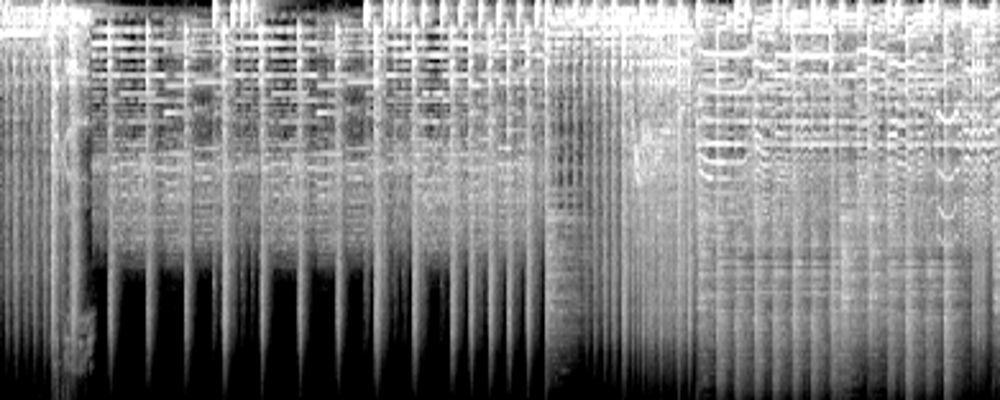

In [7]:
SG.resize((1000,400))

In [8]:
Audio(valid_batch.to("cpu").numpy()[0],rate=44100)

In [9]:
import torch
import torch.nn as nn
import numpy as np
import einops
from pytorch_wavelets import DWT1DForward, DWT1DInverse
import diffusers.models.autoencoders as autoencoders 

class Round(nn.Module):
    def __init__(self):
        super(Round, self).__init__()
    def forward(self, x):
        if self.training:
            noise = torch.rand_like(x) - 0.5
            return x + noise
        else:
            return torch.round(x)
        
class AudioWalloc(nn.Module):
    def __init__(self, channels, J, Ne, Nd, latent_dim, latent_bits, lightweight_encode):
        super().__init__()
        self.channels = channels
        self.J = J
        self.freq_bands = 2**J
        self.Ne = Ne
        self.Nd = Nd
        self.latent_dim = latent_dim
        self.latent_bits = latent_bits
        self.latent_max = 2**(latent_bits-1)-1+0.5-1e-3
        self.wt  = DWT1DForward(J=1, mode='periodization', wave='bior4.4')
        self.iwt = DWT1DInverse(mode='periodization', wave='bior4.4')
        self.clamp = torch.nn.Hardtanh(min_val=-0.5, max_val=0.5)

        entropy_bottleneck = [
            torch.nn.Hardtanh(min_val=-self.latent_max, max_val=self.latent_max),
            Round()
        ]

        if lightweight_encode:
            self.encoder = nn.Sequential(
                nn.Conv2d(
                    in_channels=self.channels * self.freq_bands,
                    out_channels=self.latent_dim,
                    kernel_size=(1, 1),
                    stride=(1, 1),
                    padding=(0, 0),
                ),
                *entropy_bottleneck
            )
        else:
            self.encoder = nn.Sequential(
                autoencoders.autoencoder_oobleck.OobleckEncoder(
                    encoder_hidden_size=self.latent_dim,
                    audio_channels=self.channels*self.freq_bands,
                    downsampling_ratios=2*[1],
                    channel_multiples=2*[self.Ne//self.latent_dim],
                ),
                *entropy_bottleneck
            )
            
        self.decoder = nn.Sequential(
                autoencoders.autoencoder_oobleck.OobleckDecoder(
                    channels=self.latent_dim,
                    input_channels=self.latent_dim,
                    audio_channels=self.channels*self.freq_bands,
                    upsampling_ratios=2*[1],
                    channel_multiples=2*[self.Nd//self.latent_dim],
                )
            )
        
    def analysis_one_level(self,x):
        L, H = self.wt(x)
        X = torch.cat([L.unsqueeze(2),H[0].unsqueeze(2)],dim=2)
        X = einops.rearrange(X, 'b c f ℓ -> b (c f) ℓ')
        return X
    
    def wavelet_analysis(self,x,J=3):
        for _ in range(J):
            x = self.analysis_one_level(x)
        return x
    
    def synthesis_one_level(self,X):
        X = einops.rearrange(X, 'b (c f) ℓ -> b c f ℓ', f=2)
        L, H = torch.split(X, [1, 1], dim=2)
        L = L.squeeze(2)
        H = [H.squeeze(2)]
        y = self.iwt((L, H))
        return y
    
    def wavelet_synthesis(self,x,J=3):
        for _ in range(J):
            x = self.synthesis_one_level(x)
        return x
            
    def forward(self, x):
        X = self.wavelet_analysis(x,J=self.J)
        Y = self.encoder(X)
        X_hat = self.decoder(Y)
        x_hat = self.wavelet_synthesis(X_hat,J=self.J)
        tf_loss = F.mse_loss( X.abs(), X_hat.abs() )
        return self.clamp(x_hat), F.mse_loss(x,x_hat), tf_loss

In [10]:
codec = AudioWalloc(
    channels=config.channels,
    J=config.J,
    Ne=config.Ne,
    Nd=config.Nd,
    latent_dim=config.latent_dim,
    latent_bits=config.latent_bits,
    lightweight_encode=config.lightweight_encode
).to(device)

optimizer = torch.optim.AdamW(
    params=codec.parameters(),
    weight_decay=0.0,
    lr = config.min_lr
)

sum(p.numel() for p in codec.parameters())/1e6

/home/dgj335/.local/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


14.78304

In [11]:
def minus_cosine_warmup(i_step):
    scale = 0.5 * (np.log10(config.max_lr) - np.log10(config.min_lr))
    angle =  np.pi * i_step / (config.warmup_steps//config.plot_update)
    log_lr = np.log10(config.min_lr) + scale * (1 - np.cos(angle))
    lr = 10 ** log_lr
    return lr/config.min_lr
    
warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: minus_cosine_warmup(i_step)
)

reduce_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.98,
    patience=config.patience,
    threshold=1e-5,
    min_lr=config.min_lr
)

In [ ]:
warnings.filterwarnings("ignore", message="Truncated File Read", category=UserWarning, module="PIL.TiffImagePlugin")
dist_losses, rate_losses = [], []
learning_rates = [optimizer.param_groups[0]['lr']]
img_displays = []
text_display = None
codec.train()
optimizer.zero_grad()
mb = master_bar(range(config.epochs))
mb.names = ['Distortion Loss', 'Smoothed']
i_step = 0
for i_epoch in mb:
    dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        drop_last=True,
        shuffle=True,
        collate_fn=collate_fn
    )
   
    for i, batch in enumerate(progress_bar(dataloader, parent=mb)):
    
        x = batch.to(device)

        _, mse_loss, tf_loss = codec(x)

        dist_loss = mse_loss + config.ϕ*tf_loss
        dist_losses.append(np.log10(dist_loss.item()))
        loss = dist_loss
        loss.backward()
        if (i + 1) % config.grad_accum_steps == 0: 
            optimizer.step()
            optimizer.zero_grad()
        
        # plotting and lr scheduler
        if len(dist_losses) % config.plot_update == 0:
            plot_n = len(dist_losses) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(dist_losses).reshape(plot_n, -1).mean(dim=1)
            dist_x = range(len(dist_losses))
            dist_y = dist_losses
            mb.update_graph([[dist_x, dist_y],[smoothed_x, smoothed_y]])
            mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

            # lr scheduler
            if i_step < config.warmup_steps:
                warmup.step()
            else:
                reduce_plateau.step(smoothed_y[-1])
            learning_rates.append(optimizer.param_groups[0]['lr'])

            with torch.no_grad():
                codec.eval()
                y_valid, _, _ = codec(valid_batch)
                write(f"valid_{device}.wav", 44100, y_valid.to("cpu").numpy()[0][0])
                buffer = io.BytesIO()
                make_spectrogram(y_valid).resize((1000,500)).save(buffer, format="PNG")
                codec.train()
            buffer.seek(0)
            if len(img_displays) == 0:
                img_displays.append(display(Image(buffer.read()), display_id=True))
            else:
                update_display(Image(buffer.read()), display_id=img_displays[0].display_id)
                
        i_step+=1
        
    torch.save({
        'model_state_dict': codec.state_dict(),
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'dist_losses': dist_losses,
        'config': config
    }, f"log_{device}.pth")

In [13]:
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

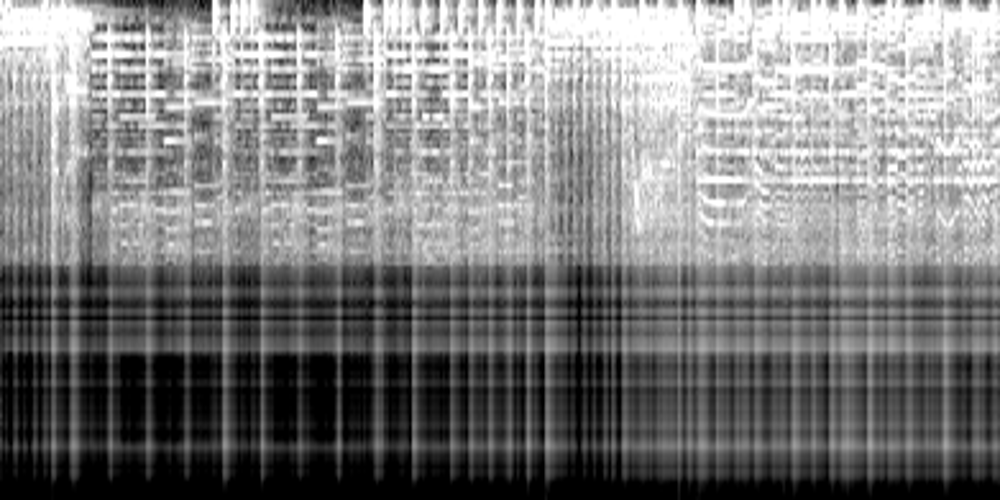

In [14]:
buffer.seek(0)
display(Image(buffer.read()))

In [15]:
valid_audio = y_valid.to("cpu").numpy()[0]
Audio(valid_audio,rate=44100)

In [17]:
torch.save({
    'model_state_dict': codec.state_dict(),
    'i_epoch': i_epoch,
    'learning_rates': learning_rates,
    'dist_losses': dist_losses,
    'config': config
}, "../../hf/walloc/stereo_v0.1.0.pth")

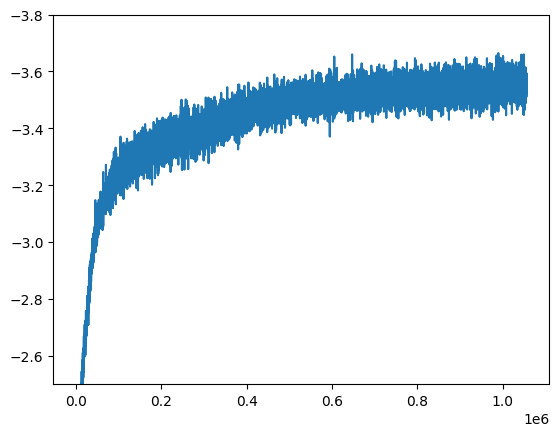

In [21]:
plt.plot(smoothed_x,smoothed_y)
plt.ylim([-2.5,-3.8]);

In [22]:
with torch.no_grad():
    X = codec.wavelet_analysis(valid_batch,codec.J)
    Z = codec.encoder[:1](X)

In [23]:
import zlib
bytes = Z.round().to(torch.int8).detach().cpu().numpy().tobytes()
print(valid_batch.numel()/len(bytes))
print(valid_batch.numel()/len(zlib.compress(bytes,level=9)))

7.9948750800768735
15.20907913778658


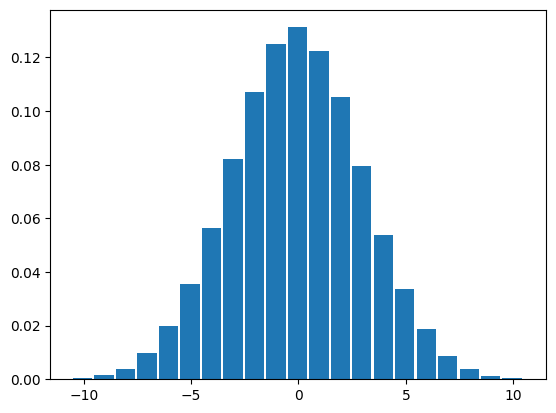

In [29]:
plt.hist(Z.to("cpu").flatten().numpy(), density=True,range=(-10.5,10.5),bins=21, width=0.9);

In [30]:
Z.std()

tensor(3.0180, device='cuda:3')